# 全局设置

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

In [2]:
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

## 加载数据

In [3]:
from regimes_yrb.tools.statistic import (
    ratio_contribution,
    plot_pettitt_change_points,
    plot_ratio_contribution,
    pettitt_changes,
)
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "out"

COLORS = cfg.style.colors
period_colors = COLORS.period
region_colors = COLORS.region
index_colors = COLORS.index

index_colormap = matplotlib.colors.ListedColormap(index_colors, "indexed")
total_water_use_color = COLORS.total_WU

In [4]:
# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(cfg.db.perfectures)

In [5]:
city_yr.head()

,City_ID,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,...,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use,Province_n,Area_calcu,Region,Intersect_area,Ratio
0,C27,1965,0.300518,46.631997,0.391448,16.089679,1.152312,0.571298,28.427261,644.445209,...,31.895556,0.003203,141.750766,0.022595,0.328586,Gansu,20091.467281,UR,19188.439369,0.955054
1,C27,1966,0.323595,49.468303,0.383836,16.485679,1.434736,0.636613,30.527440,654.146772,...,28.371723,0.003336,147.646616,0.022592,0.351996,Gansu,20091.467281,UR,19188.439369,0.955054
2,C27,1967,0.340063,52.309331,0.416675,17.803304,1.442818,0.697033,31.949501,650.100439,...,21.033715,0.003413,151.033245,0.022600,0.372432,Gansu,20091.467281,UR,19188.439369,0.955054
3,C27,1968,0.352690,53.870788,0.437429,18.863369,1.514685,0.770592,32.284713,654.695280,...,22.233352,0.003487,154.266500,0.022604,0.391458,Gansu,20091.467281,UR,19188.439369,0.955054
4,C27,1969,0.365740,55.120730,0.447621,19.700679,1.549920,0.752680,32.669830,663.524461,...,32.825618,0.003575,158.251492,0.022594,0.406136,Gansu,20091.467281,UR,19188.439369,0.955054


## IWGI计算

我们认为水资源利用制度，与水资源利用的三个维度紧密相关：
- 用水压力（stress, S）
- 用水优先性（configuration, P）
- 用水配置（priority, C）

根据经验，我们认为这三者与社会发展$(Dev.)$具有方向性关系:

- 社会的发展通常伴随着用水向社会经济系统倾斜，用水方式优先向收益更高的非供给性方式倾斜：
$$ Dev \propto P $$
- 社会发展通常伴随着更具结构性的水资源配置，如区域部门之间的分工合作，以及区域的统筹配置：
$$ Dev \propto C $$ 
- 可持续的社会发展应该通过技术手段有效缓解发展过程中产生的水资源压力，才能实现可持续发展：
$$ Dev \propto S^{-1} $$

将三者合一起，即：
$$ Dev. \propto P*C*S^{-1} $$

在上述假设的基础上，我们要构建流域综合耦合指数(Integrated Water Resources Utilization, IWRU)，使 IWRU 有效表征与用水相关的三个维度。首先为每个维度选择一个合适的指示因子（indicator, $I_x$, 其中$x=P, C or S$）。将上式进行自然对数转换，从而让三个维度之间变成加减关系：
$$ Dev. \propto ln(I_P) + ln(I_C) - ln(I_S) $$

然后为了给定 IWRU 确定的值域，同时让三个维度之间等权重，对三者进行标准化处理，得到我们的综合耦合指数 IWRU：
$$ IWRU = norm(ln(I_P)) + norm(ln(I_C)) - norm(ln(I_S)) $$

In [6]:
from regimes_yrb.index import integrated_water_governance_index

sfv = pd.read_csv(cfg.db.results.S, index_col=0).iloc[:, 0]
priority = pd.read_csv(cfg.db.results.P, index_col=0).iloc[:, 0]
allocation = pd.read_csv(cfg.db.results.A, index_col=0).iloc[:, 0]

iwgi = integrated_water_governance_index(
    priority=priority,
    scarcity=sfv,
    allocation=allocation,
)

# 导出数据
iwgi.to_csv(cfg.db.results.IWGI)

## Fig.3 三元图

对三元图来说，计算的是每个维度 $X$ 对 regime 的影响（Impact）

$$ Impact_X = \frac{I'_X}{\sum_X I'_X} $$

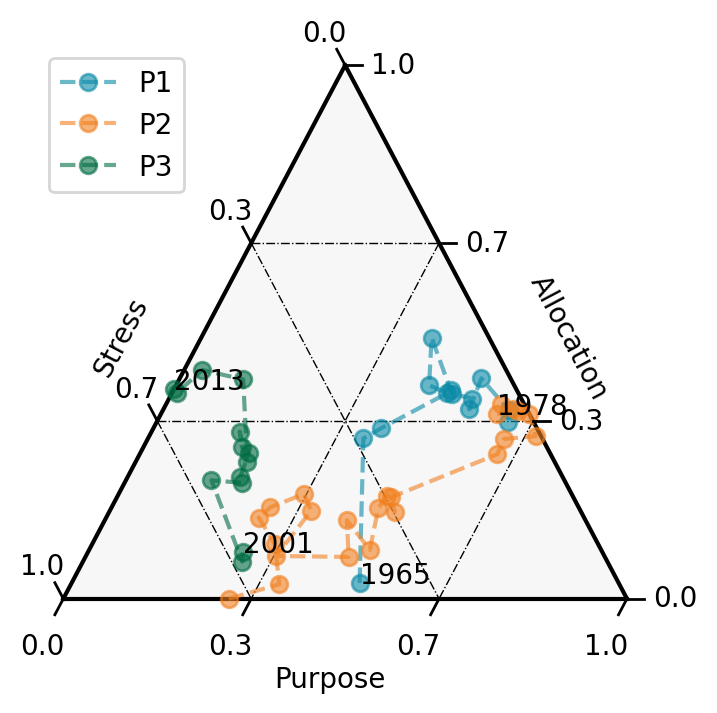

In [7]:
from regimes_yrb.plot import plot_ternary

ax = plot_ternary(iwgi)
# plt.savefig("../figures/main/phases.jpg", dpi=300)
# plt.savefig("../figures/main/phases.pdf", dpi=300)
plt.show();

## 计算贡献度

首先是计算各个指标（$I_x, x = P, S, or C$）的贡献度：

$$ IWRU = I'_P + I'_C - I'_S $$

对每个起始年份为$y1$，截止年份为$y2$的时间段，有：

$$ \Delta IWRU = IWRU_{y2} - IWRU_{y1} $$

即：

$$ \Delta IWRU = (I'_{P_{y2}} + I'_{C_{y2}} - I'_{S_{y2}}) - (I'_{P_{y1}} + I'_{C_{y1}} - I'_{S_{y1}}) = \Delta I'_P + \Delta I'_C + (-\Delta I'_S) $$

则每个指标$x$ ($P$, $C$, or $S$)对IWRU变化量的贡献度$Contribution_x$为：

$$ Contribution_x = \frac{\Delta I'_x}{|\Delta IWRU|} $$

其影响是：

$$ Impact_X = \frac{\Delta I'_X}{\sum_X |\Delta I'_X|} $$

In [8]:
from regimes_yrb.index import calc_contribution

changes_contribution = calc_contribution(iwgi, threshold=cfg.alpha_threshold)
changes_contribution

# 各个指数对 iwru 在每个阶段发生变化的贡献量
print("第三阶段 Allocation(A) 的贡献是较第二阶段增长的倍数：")
changes_contribution["A"].iloc[2] / changes_contribution["A"].iloc[1] - 1

print("第三阶段 Priority (P) 的贡献是较第二阶段增长的倍数：")
changes_contribution["P"].iloc[2] / changes_contribution["P"].iloc[1] - 1

print("第三阶段 Stress (S) 的贡献是较第二阶段增长的倍数：")
changes_contribution["S"].iloc[2] / changes_contribution["S"].iloc[1] - 1

,P,A,S
P1: 1965-1977,0.046087,0.447457,0.735346
P2: 1978-2000,-0.395170,-0.445970,-0.827218
P3: 2001-2013,-0.399256,0.509170,-0.056328


第三阶段 Allocation(A) 的贡献是较第二阶段增长的倍数：


-2.1417148920135096

第三阶段 Priority (P) 的贡献是较第二阶段增长的倍数：


0.010340785531333996

第三阶段 Stress (S) 的贡献是较第二阶段增长的倍数：


-0.9319068776877985

## 计算相关系数

In [9]:
from regimes_yrb.index import calc_index_correlation

corr_results, k_results, p_results = calc_index_correlation(iwgi)

## 最终作图

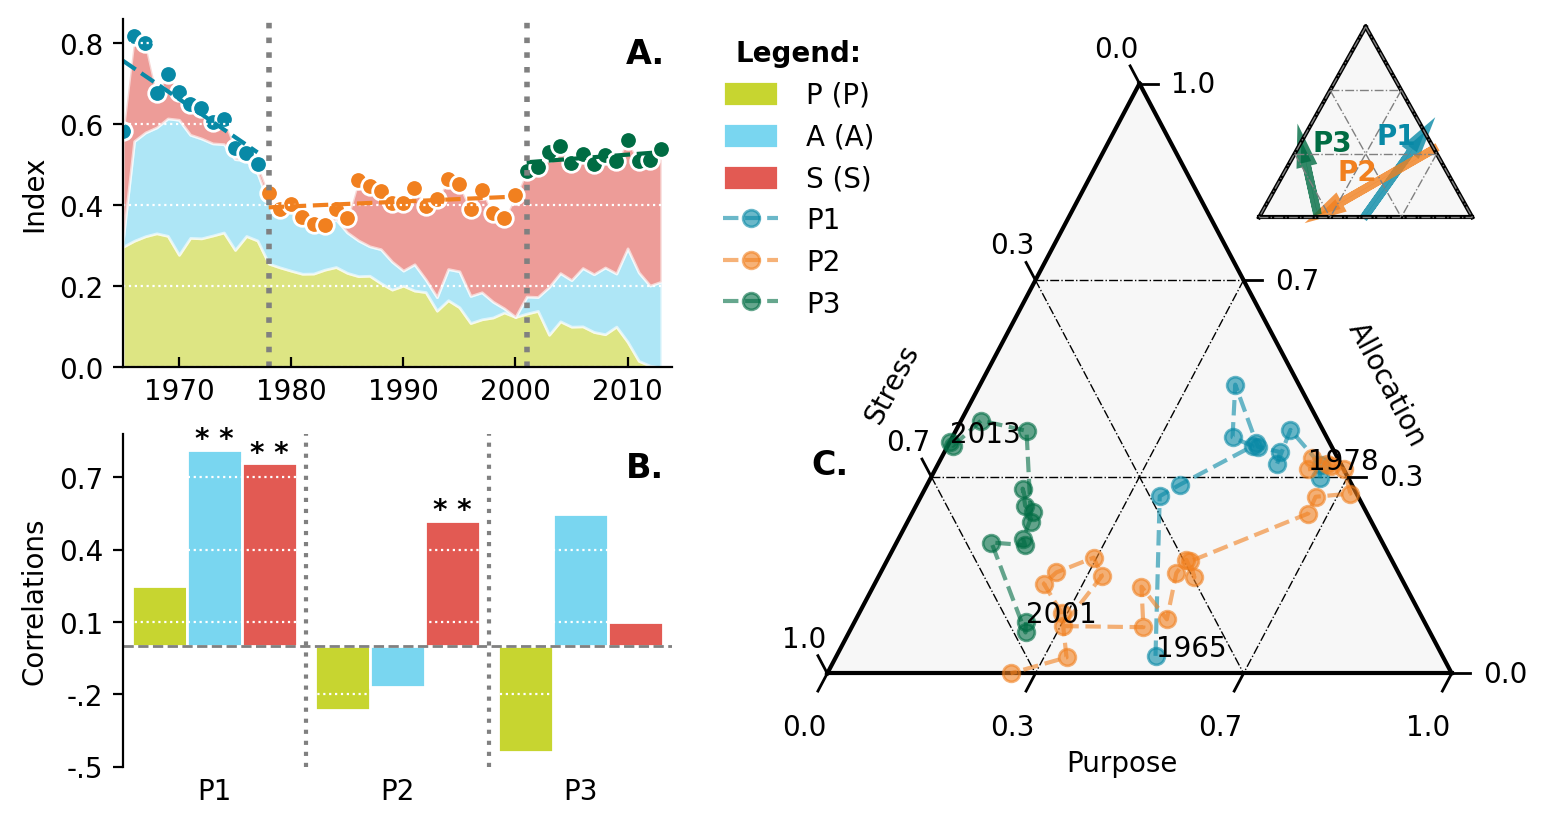

In [10]:
from regimes_yrb.plot import plot_demonstrate, plot_pettitt_change_points
from regimes_yrb.tools.plot_support import get_position_by_ratio


# 绘图
fig = plt.figure(constrained_layout=False, figsize=(8, 4.4))
fig.subplots_adjust(left=0.10, right=0.95, top=0.95, bottom=0.10)

gs = GridSpec(
    5,
    2,
    figure=fig,
    width_ratios=[4, 5],
    height_ratios=[0.05, 1, 0.05, 1, 0.0],
)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[3:5, 0])
ax3 = fig.add_subplot(gs[1:-1, 1])
ax4 = fig.add_subplot(355)
plot_demonstrate(ax4)

tax = plot_ternary(iwgi, ax=ax3)

# 使用【堆积图】绘制子区域
labels = ["P", "A", "S"]
ys = [iwgi[col] / 3 for col in labels]
ax1.stackplot(
    iwgi.index,
    *ys,
    colors=index_colors,
    alpha=0.6,
    zorder=0,
    labels=labels,
    edgecolor="white",
)
wcci_slopes = plot_pettitt_change_points(
    iwgi["IWGI"],
    ax=ax1,
    colors=period_colors,
    p_shr=cfg.alpha_threshold,
    edgecolor="white",
    s=40,
)

# 绘制相关系数
# corr_results.columns = ["scarcity", "priority", "allocation"]
corr_results[labels].plot.bar(
    ax=ax2, colormap=index_colormap, edgecolor="white", width=0.9
)

ys = [iwgi[col] / 3 for col in labels]


# 修饰图片1
# ax1.set_xlabel('Year')
ax1.set_ylabel("Index")
ax1.set_xlim(1965, 2014)
# ax1.set_ylim(0.04, 0.105)
# ax1.set_yticks(np.arange(0.04, 0.105, 0.02))
# ax1.text(1968, 0.4, 'A.', ha='center', va='center', weight='bold', size='large')
ax1.legend(loc="upper right", ncol=2)

# 修饰图片3
# ax3.set_xlabel("Different periods")
ax2.set_ylabel("Correlations")
for tick in ax3.get_xticklabels():  # 旋转角度
    tick.set_rotation(0)  # 轴标签旋转
ax2.axhline(y=0, c="gray", lw=1, ls="--")
# ax3.set_xticklabels(["1965-1977", "1978-2000", "2001-2013"])
ax2.set_yticks(np.arange(-0.5, 0.8, 0.3))
ax2.set_yticklabels(["-.5", "-.2", "0.1", "0.4", "0.7"])
ax2.tick_params(axis="x", tickdir="in", bottom=False, labelrotation=0)
# ax3.text(-0.2, 0.7, 'B.', ha='center', va='center', weight='bold', size='large')
ax2.axvline(1.5, ls=":", color="gray")
ax2.axvline(0.5, ls=":", color="gray")
ax2.set_xlim(-0.5, 2.5)

v_space = 0.01
for i, period in enumerate(corr_results.index):
    for j, indicator in enumerate(corr_results.columns):
        height = corr_results[labels].iloc[i, j] + v_space
        location = i + (-0.3, 0, 0.3)[j]
        if p_results[labels].iloc[i, j] < 0.05:
            ax2.text(
                location,
                height,
                "* *",
                horizontalalignment="center",
                weight="bold",
                color="black",
            )

# 调整坐标轴显示
for ax in [ax1, ax2, ax4]:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", color="white", ls=":")

ax1.spines["bottom"].set_visible(True)
ax4.spines["left"].set_visible(False)

legend_handles = []
legend_labels = []
for handle, label in zip(*ax2.get_legend_handles_labels()):
    legend_handles.append(handle)
    legend_labels.append(label.title() + f" ({label[0].title()})")

for handle, label in zip(*ax3.get_legend_handles_labels()):
    legend_handles.append(handle)
    legend_labels.append(label)

for i, ax in enumerate([ax1, ax2, ax3]):
    ax.get_legend().remove()
    ratio_x, ratio_y = 0.95, 0.9
    if i == 2:
        ratio_x = 0.05
        ratio_y = 0.406
    x, y = get_position_by_ratio(ax, ratio_x, ratio_y)
    label = ["A.", "B.", "C."][i]
    ax.text(x, y, label, ha="center", va="center", weight="bold", size="large")

fig.legend(
    loc=(0.46, 0.60),
    ncol=1,
    handles=legend_handles,
    labels=legend_labels,
    handletextpad=1,
    handleheight=1,
    markerscale=1,
    frameon=False,
    title="Legend:",
    title_fontproperties={"weight": "bold", "size": 10},
)

# 储存和显示图片
# plt.savefig("../figures/main/index.pdf", dpi=300)
# plt.savefig("../figures/main/index.jpg", dpi=300)
plt.show();

In [11]:
corr_results

,S,P,A
P1,0.758242,0.248352,0.815385
P2,0.519130,-0.264348,-0.168696
P3,0.098901,-0.439560,0.549451


## 对阈值变化的敏感性分析